In [1]:
import urllib
import os
import pathlib
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

In [10]:
DATA_ROOT = '../data/'
READ_DIR = os.path.join(DATA_ROOT, 'raw/bos_analyze')
SHAPE_DIR = os.path.join(DATA_ROOT, 'raw/shapefile')
WRITE_DIR = os.path.join(DATA_ROOT, 'interim')
readfile_prop = os.path.join(READ_DIR, 'property_assess/fy19fullpropassess.csv')
readfile_sam = os.path.join(READ_DIR, 'SAMaddresses.csv')
readfile_zip = os.path.join(SHAPE_DIR, 'ZIP_Codes.shp')

print(readfile_prop, readfile_sam, readfile_zip)

../data/raw/bos_analyze/property_assess/fy19fullpropassess.csv ../data/raw/bos_analyze/SAMaddresses.csv ../data/raw/shapefile/ZIP_Codes.shp


In [14]:
df_sam = pd.read_csv(readfile_sam, dtype=str)
df_prop = pd.read_csv(readfile_prop, dtype=str)
df_sam['X'] = df_sam['X'].astype(float)
df_sam['Y'] = df_sam['Y'].astype(float)

In [20]:
# set the filepath and load in a shapefile
zipshape_df = gpd.read_file(readfile_zip)

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
zipshape_df.head()

,OBJECTID,ZIP5,ShapeSTAre,ShapeSTLen,geometry
0,1,02134,3.721936e+07,40794.182396,POLYGON ((-71.12340461235522 42.36420867214283...
1,2,02125,6.476052e+07,62224.521440,POLYGON ((-71.04541458491363 42.32380666715233...
2,3,02110,6.637284e+06,18358.213496,POLYGON ((-71.05109058896998 42.36418367507441...
3,4,02118,3.116158e+07,32353.407618,POLYGON ((-71.06315159137533 42.34688867055895...
4,5,02126,6.078585e+07,45488.394711,POLYGON ((-71.09669659978795 42.29095065982932...


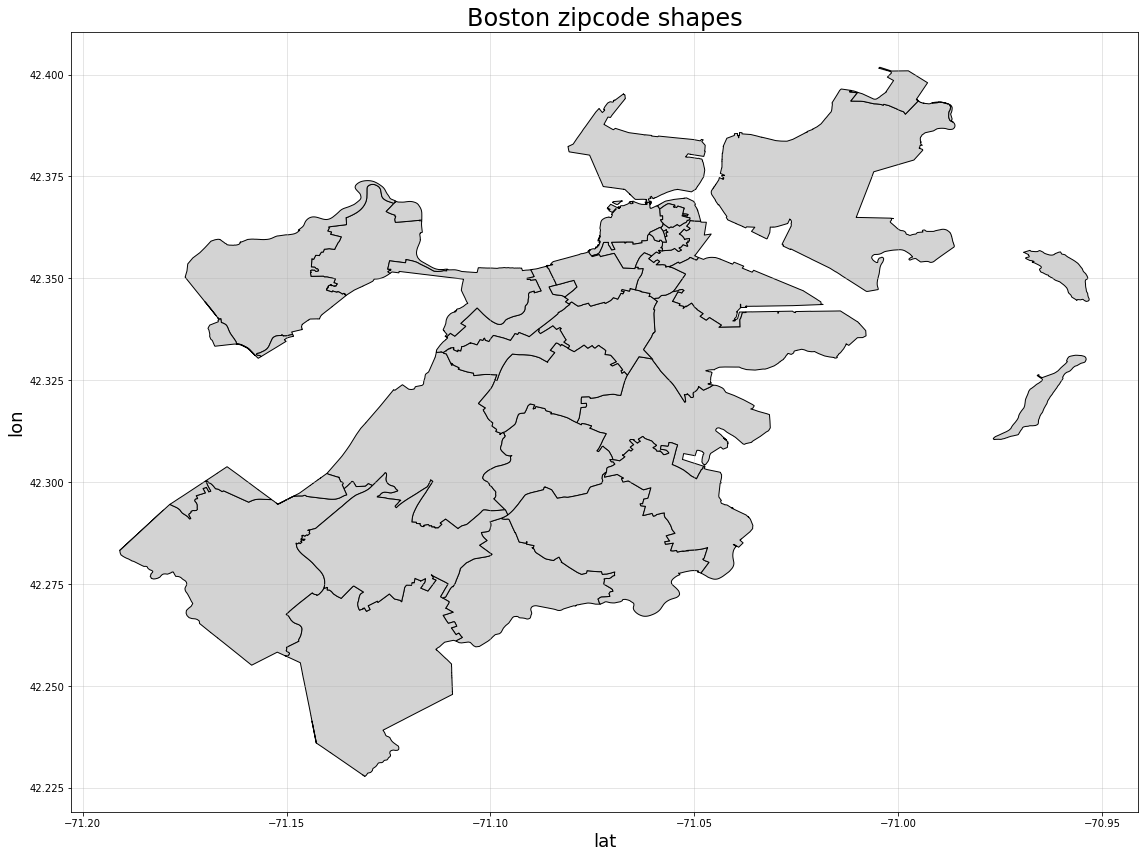

In [13]:
fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Boston zipcode shapes',
    fontsize=24
)

# note that the geopandas dataframe object, has a .plot() method for easy plotting
zipshape_df.plot(ax=ax, color='lightgray', edgecolor='k')

plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

In [21]:
# To label each shape, we first need to find a "representative point" for each polygon geometry
# shapely (built into geopandas) can handle this with the representative_point() method

zipshape_df['coords'] = zipshape_df['geometry'].apply(lambda x: x.representative_point().coords[:])
zipshape_df['coords'] = [coords[0] for coords in zipshape_df['coords']]

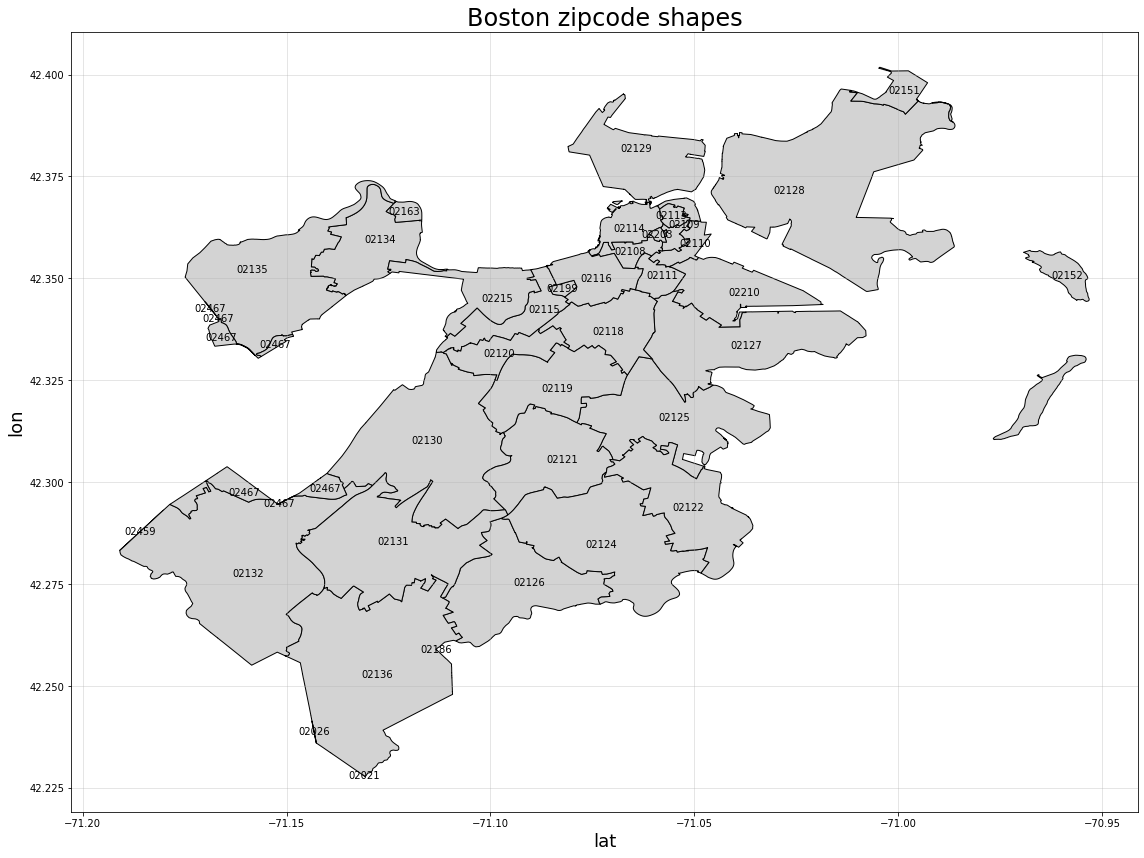

In [25]:
# and then using matplotlib's annotate() method, we can print to our map

fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Boston zipcode shapes',
    fontsize=24
)

zipshape_df.plot(ax=ax, color='lightgray', edgecolor='k')

# here we use the geopandas dataframe object's built-in iterrows() method
# to turn zipshape_df into a generator object for iteration
for idx, row in zipshape_df.iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center'
    )

plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

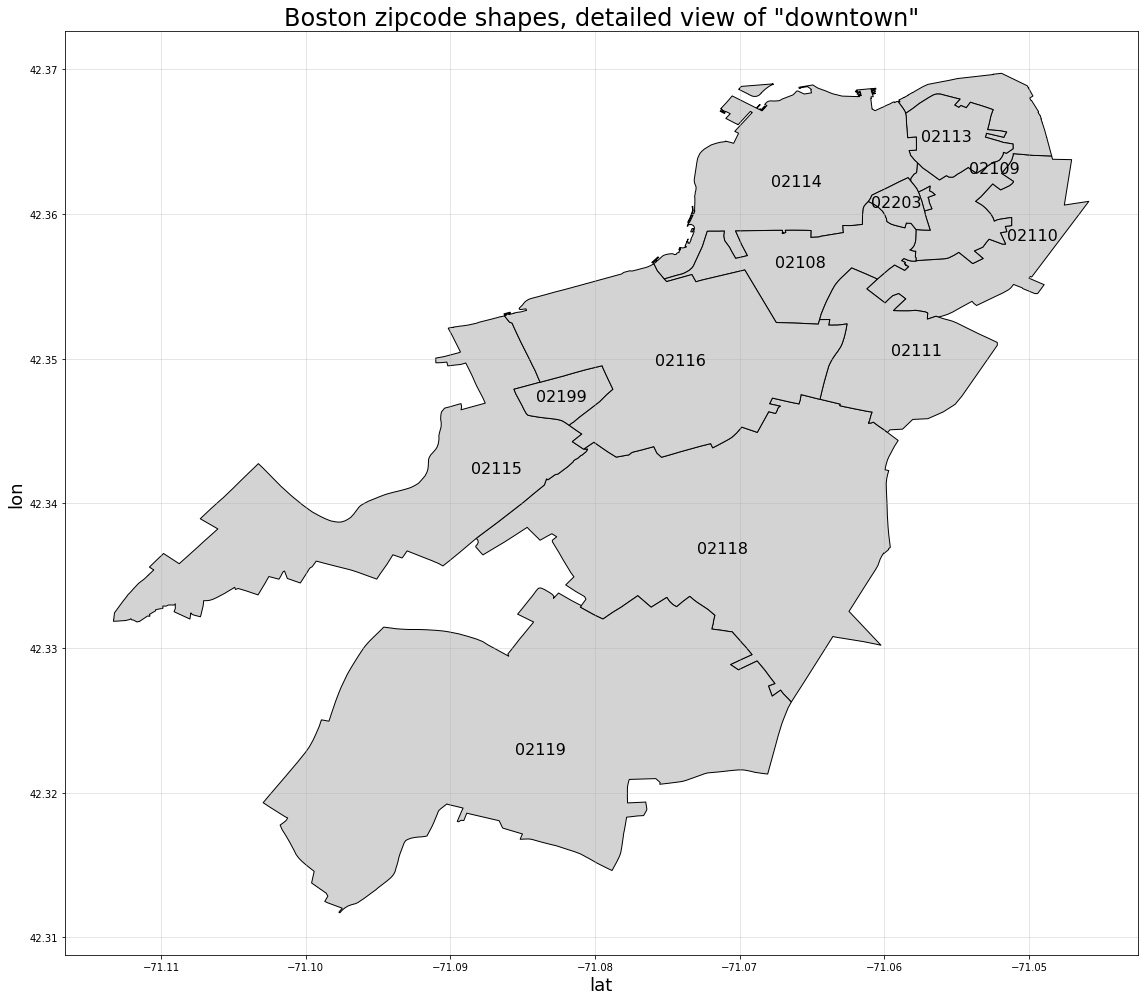

In [34]:
# and then using .loc[] we can subset our geopandas dataframe to plot only
# a subset of our zipcodes, perhaps to zoom in and make the downtown zipcodes easier to see

loc = (
    (zipshape_df['ZIP5'].str.contains('0211')) |
    (zipshape_df['ZIP5'].str.contains('0210')) |
    (zipshape_df['ZIP5'] == '02199') |
    (zipshape_df['ZIP5'] == '02203')
)

fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Boston zipcode shapes, detailed view of "downtown"',
    fontsize=24
)

zipshape_df.loc[loc].plot(ax=ax, color='lightgray', edgecolor='k')

for idx, row in zipshape_df.loc[loc].iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=16
    )

plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

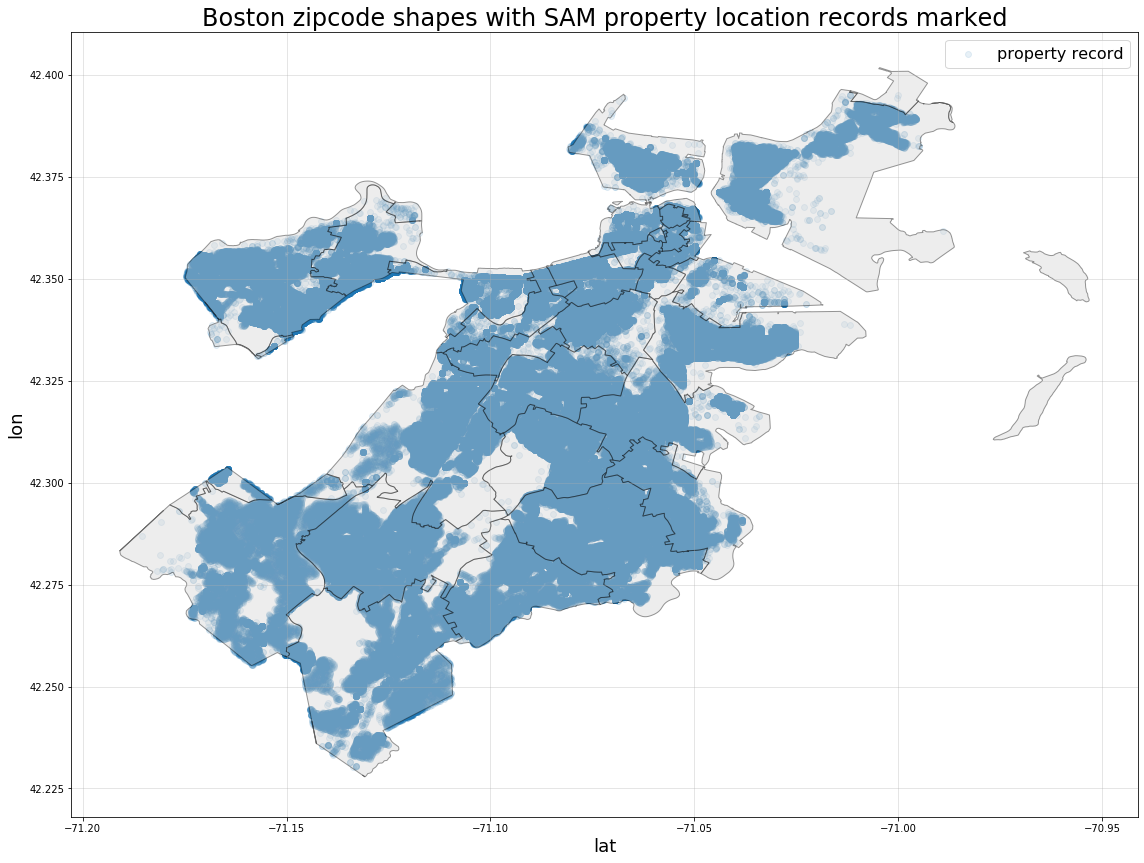

In [36]:
# using basic matplotlib plotting funtions, we can also layer our data along with the shapes 
fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Boston zipcode shapes with SAM property location records marked',
    fontsize=24
)

plt.scatter(df_sam['X'], df_sam['Y'], alpha=0.1, label='property record')

zipshape_df.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)


plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show();

In [47]:
# now to create a summary table from the SAM addresses for visuallizing
# density by ZIP with our shapefile

prop_count_by_zip = df_sam.groupby('ZIP_CODE').agg(
    {'ZIP_CODE':'count'}
).rename({'ZIP_CODE': 'properties'}, axis=1)

print(prop_count_by_zip.shape)
prop_count_by_zip.head()

(37, 1)


,properties
ZIP_CODE,
02026,1
02108,4366
02109,4392
02110,3555
02111,6092


In [46]:
# zipcode_prop_df = zipshape_df.set_index('ZIP5').join(prop_count_by_zip)
# Now to merge with our shapefile polygon geometries dataframe
zipcode_prop_df = zipshape_df.join(prop_count_by_zip, on='ZIP5')

print(zipcode_prop_df.shape)
zipcode_prop_df.head()

(43, 7)


,OBJECTID,ZIP5,ShapeSTAre,ShapeSTLen,geometry,coords,properties
0,1,02134,3.721936e+07,40794.182396,POLYGON ((-71.12340461235522 42.36420867214283...,"(-71.12704824441153, 42.35944218076044)",14644.0
1,2,02125,6.476052e+07,62224.521440,POLYGON ((-71.04541458491363 42.32380666715233...,"(-71.05487618131991, 42.31578366454911)",19400.0
2,3,02110,6.637284e+06,18358.213496,POLYGON ((-71.05109058896998 42.36418367507441...,"(-71.04976610342825, 42.35849650724344)",3555.0
3,4,02118,3.116158e+07,32353.407618,POLYGON ((-71.06315159137533 42.34688867055895...,"(-71.07117288285457, 42.33688916926195)",19608.0
4,5,02126,6.078585e+07,45488.394711,POLYGON ((-71.09669659978795 42.29095065982932...,"(-71.09036847374043, 42.275358656948306)",14376.0


In [51]:
zipcode_prop_df['properties'].describe()

count       38.000000
mean     10621.263158
std       8877.230179
min          1.000000
25%        921.000000
50%      11822.500000
75%      15472.000000
max      30071.000000
Name: properties, dtype: float64

In [ ]:
# now we can generate a choropleth plot of property record densities by ZIP 

# set the range for the choropleth
# vmin, vmax = 120, 220

merged.plot(column=variable, cmap=’Blues’, linewidth=0.8, ax=ax, edgecolor=’0.8')

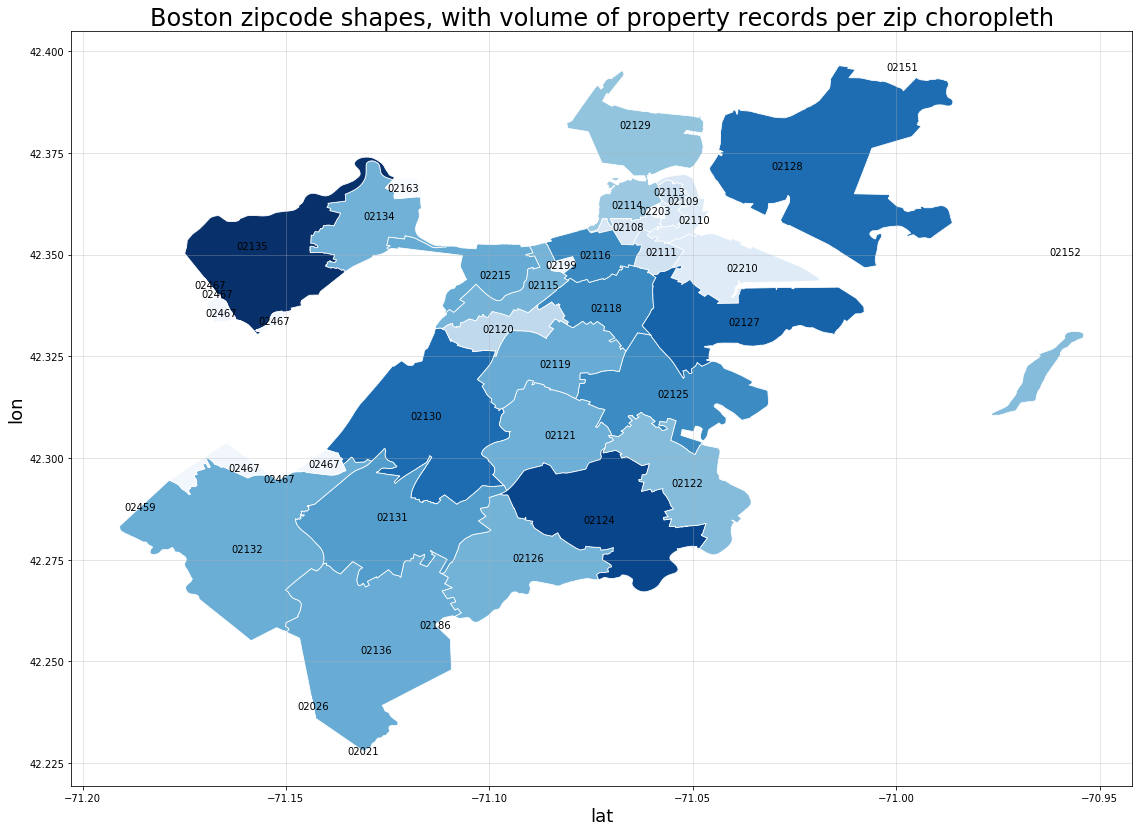

In [55]:
variable = 'properties'

fig, ax = plt.subplots(figsize=(16,16))

plt.title(
    'Boston zipcode shapes, with volume of property records per zip choropleth',
    fontsize=24
)

# NOTE: null values must be dropped from our df (as is shown below).
#       Otherwise, the choropleth does not provide any gradation in color
zipcode_prop_df.dropna(subset=[variable]).plot(
    column=variable,
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='white'
)

# here we use the geopandas dataframe object's built-in iterrows() method
# to turn zipshape_df into a generator object for iteration
for idx, row in zipshape_df.iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center'
    )

plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

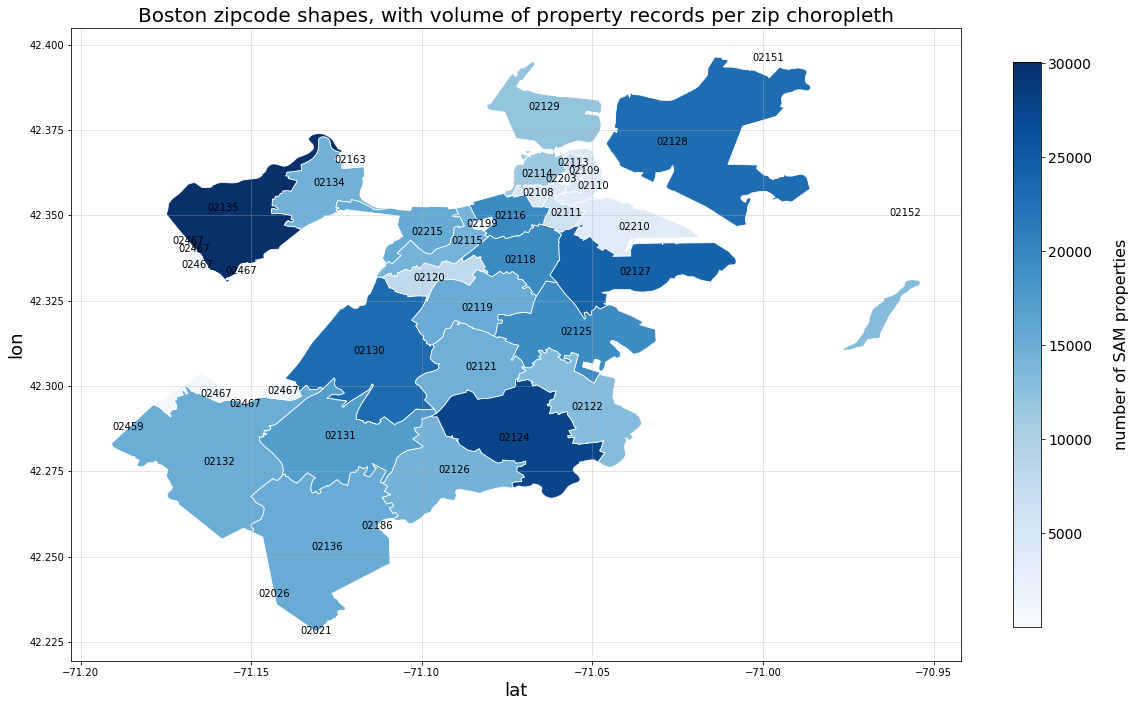

In [75]:
# Or, the same plot, but with a colorbar added for better interpretability
variable = 'properties'

# set min and max variable values for use in plotting our colorbar
vmin = zipcode_prop_df[variable].describe()['min']
vmax = zipcode_prop_df[variable].describe()['max']

fig, ax = plt.subplots(figsize=(16,16))

plt.title(
    'Boston zipcode shapes, with volume of property records per zip choropleth',
    fontsize=20
)

# NOTE: null values must be dropped from our df (as is shown below).
#       Otherwise, the choropleth does not provide any gradation in color
zipcode_prop_df.dropna(subset=[variable]).plot(
    column=variable,
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='white'
)

# here we use the geopandas dataframe object's built-in iterrows() method
# to turn zipshape_df into a generator object for iteration
for idx, row in zipshape_df.iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center'
    )
    
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data ranges
# add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax, shrink=.5, fraction=0.1)
cbar.set_label(label='\nnumber of SAM properties', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();